# Pytorch experiments


In [1]:
import matplotlib.pyplot as plt
import re
import numpy as np
%matplotlib inline

In [2]:
from dataloader import DataLoader, distance
from os.path import abspath
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
print(abspath('./'))
loader = DataLoader(10)
loader.parse_person_corpus(abspath('../Persons-1000/collection'))
loader.parse_rdf_corpus(abspath('../../corpus_for_pakhomov_2'))

C:\Users\Sdernal\Desktop\Jackals\TextNormalization\WithPytorch
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Абдулла Гюль.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Адам Осмаев.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Азим Исабеков.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Глухов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Ломая.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Медведько.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Анатолий Бибилов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Андрей Аршавин.xml
'None

In [3]:
diffs = []
for entry in loader.entries:
    entry_start = entry.offset - entry.context_offset
    entry_end = entry_start + entry.length
    entry_text = entry.context[entry_start:entry_end]
    diff_len = abs(len(entry_text) - len(entry.value))
    diffs.append(diff_len)

(array([ 21970.,   7444.,   4194.,    650.,   1038.,    809.,    858.,
           979.,    539.,    205.,    193.,     61.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Patch objects>)

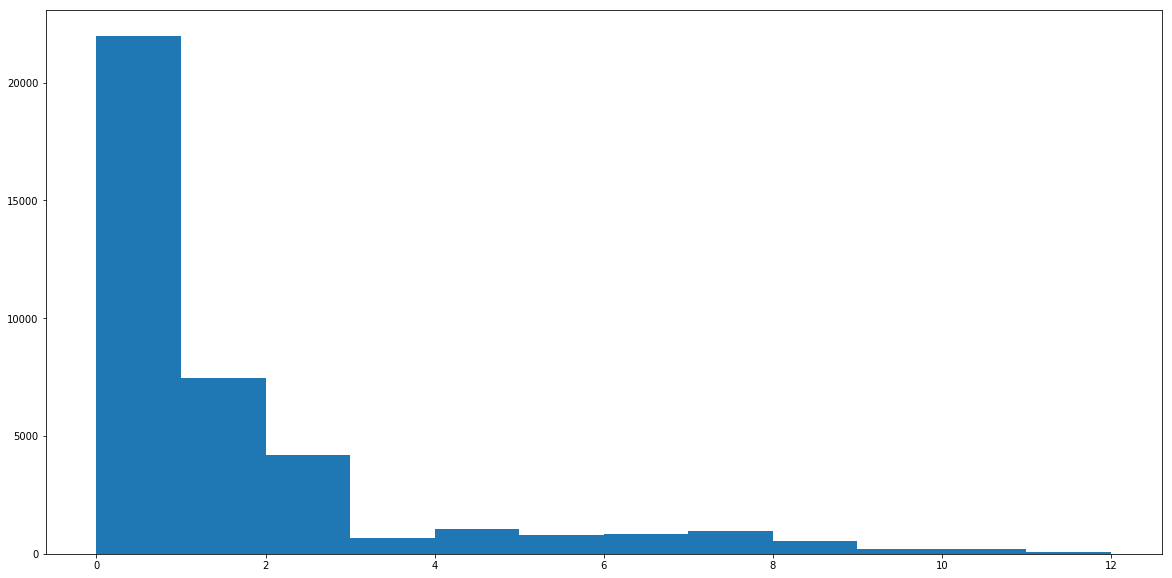

In [4]:
fig = plt.figure(figsize=(20,10))
plt.hist(diffs, range=(0,12), bins=range(0,13))

In [5]:
def words(text):
    wds = filter(lambda x: len(x) > 0, re.split('\.|-| ', text))
    return list(wds)

def delete_excess(text, value):
    text_words = text.split()
    value_words = value.split()
#     if len(value_words) < len(text_words):
#         print('\t', text,'\t', value)
#         return None
    result = []
    for t in text_words:
        for v in value_words:
            if distance(t, v) < 3:
                result.append(v)
    if len(text_words) == len(result):
#         print('\t', text,'\t', ' '.join(result), '\t', value)
        return ' '.join(result)

In [6]:
bad_entries = []
edited_enties = []
for entry in loader.entries:
    entry_start = entry.offset - entry.context_offset
    entry_end = entry_start + entry.length
    entry_text = entry.context[entry_start:entry_end]
    diff_len = abs(len(words(entry_text)) - len(words(entry.value)))
    if diff_len > 0:  
        try_to_fix = delete_excess(entry_text, entry.value)
        if try_to_fix is None:
            bad_entries.append(entry)
        else:
            entry.value = try_to_fix
#             print(entry)
            edited_enties.append(entry)
    else:
        edited_enties.append(entry)

In [7]:
len(bad_entries)
# for entry in bad_entries:
#     print(entry)

99

In [8]:
print(len(edited_enties))
uniq_values = set([entry.value for entry in edited_enties])
print(len(uniq_values))

38854
14848


In [9]:
ep = EntriesProcessor(20,40)
# voc_size = 10
ep.process(edited_enties)
voc_size = ep.symbols_counter

In [10]:
print(len(ep.X_data_test), len(ep.X_data_train))

3468 30299


# RL GAMES

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [12]:
train_losses_all, test_losses_all = [], []

In [15]:
train_losses, test_losses = trainer.train(20, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.047149 	 Time: 28s
	Test Loss: 0.134371 	 Time: 0s
Epoch 2
	Train Loss: 0.048899 	 Time: 30s
	Test Loss: 0.111913 	 Time: 0s
Epoch 3
	Train Loss: 0.041256 	 Time: 28s
	Test Loss: 0.108200 	 Time: 0s
Epoch 4
	Train Loss: 0.035729 	 Time: 27s
	Test Loss: 0.112113 	 Time: 0s
Epoch 5
	Train Loss: 0.042183 	 Time: 29s
	Test Loss: 0.115296 	 Time: 0s
Epoch 6
	Train Loss: 0.033675 	 Time: 29s
	Test Loss: 0.108469 	 Time: 0s
Epoch 7
	Train Loss: 0.030191 	 Time: 28s
	Test Loss: 0.118575 	 Time: 0s
Epoch 8
	Train Loss: 0.031793 	 Time: 29s
	Test Loss: 0.115006 	 Time: 0s
Epoch 9
	Train Loss: 0.031838 	 Time: 28s
	Test Loss: 0.115250 	 Time: 0s
Epoch 10
	Train Loss: 0.029788 	 Time: 28s
	Test Loss: 0.114145 	 Time: 0s
Epoch 11
	Train Loss: 0.037522 	 Time: 28s
	Test Loss: 0.109211 	 Time: 0s
Epoch 12
	Train Loss: 0.038552 	 Time: 29s
	Test Loss: 0.161115 	 Time: 0s
Epoch 13
	Train Loss: 0.042801 	 Time: 28s
	Test Loss: 0.105125 	 Time: 0s
Epoch 14
	Train Loss: 0.028035 	 

In [16]:
# RL max generator
ethalons, results, inputs, matched, distances = trainer.test_model(False)
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.832756632065
Mean distance:  0.217416378316


In [15]:
# random generator
ethalons, results, inputs, matched, distances = trainer.test_model(False)
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.721878862794
Mean distance:  0.411001236094


In [16]:
# max generator 
# ethalons, results, inputs, matched, distances = trainer.test_model(False)
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.87006838506
Mean distance:  0.164124145187


# AttnModel with Adam optimizer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [12]:
train_losses_all, test_losses_all = [], []

In [29]:
train_losses, test_losses = trainer.train(1, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.023083 	 Time: 23s
	Test Loss: 0.034610 	 Time: 0s


In [17]:
train_losses, test_losses = trainer.train(1, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.039014 	 Time: 23s
	Test Loss: 0.037828 	 Time: 0s


In [21]:
ethalons, results, inputs, matched, distances = trainer.test_model(False)
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.884684684685
Mean distance:  0.148648648649


In [32]:
ethalons, results, inputs, matched, distances = trainer.test_model(False)

In [33]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.904804804805
Mean distance:  0.124324324324


In [34]:
import pandas as pd
encoded_inputs = list(map(lambda x : x.encode('windows-1251', errors='replace').decode('windows-1251'), inputs))
data = {'ethalon' : ethalons, 'result' : results, 'input' : encoded_inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])
df.head(5)

,ethalon,result,input,matched,distance
0,дэниэл фрид,дэниэл фрид,"етаря сша дэниэлом фридом.\n\r\n\r""с ро",True,0
1,владимир путин,владимир путин,онце июля владимир путин на совеща,True,0
2,путин,путин,недоимки. путин попросил,True,0
3,путин,путин,а котором путин раскритик,True,0
4,путин,путин,"по мнению путина, это дела",True,0


In [35]:
df.to_csv('results_attn_adam3.csv', encoding='windows-1251')

In [60]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[60:61])

['#', '#', 'н', 'а', 'з', 'н', 'а', 'ч', 'е', 'н', 'а', '_', 'м', 'а', 'р', 'и', 'а', 'н', 'н', 'а', '_', 'к', 'о', 'к', 'у', 'н', 'о', 'в', 'а', '\n', '\r', '\n', '\r', 'и', 'с', 'п', 'о', 'л', 'н', '#']
['м', 'а', 'р', 'и', 'а', 'н', 'н', 'а', '_', 'к', 'о', 'к', 'у', 'н', 'о', 'в', 'а', '#', '#', '#']


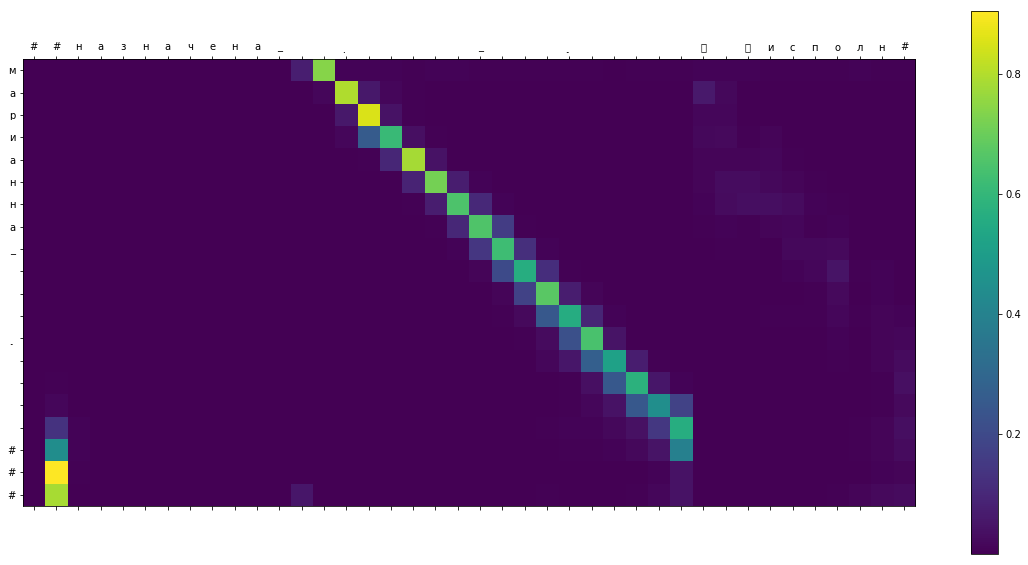

In [61]:
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
print(b2)
showAttention(a2,b2,c)

# AttnModel

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [13]:
train_losses_all, test_losses_all = [], []

In [76]:
train_losses, test_losses = trainer.train(1, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.039166 	 Time: 23s
	Test Loss: 0.061804 	 Time: 0s


In [77]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[8:9])

In [37]:
from matplotlib import ticker
def showAttention(input, result, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['#'] + input)
    ax.set_yticklabels(['#'] + result)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


['#', '#', 'г', 'о', 'с', 'п', 'о', 'д', 'и', 'н', 'а', '_', 'х', 'а', 'б', 'и', 'р', 'о', 'в', 'а', '_', 'в', '_', 'п', 'а', 'р', 'т', 'и', 'и', '_', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


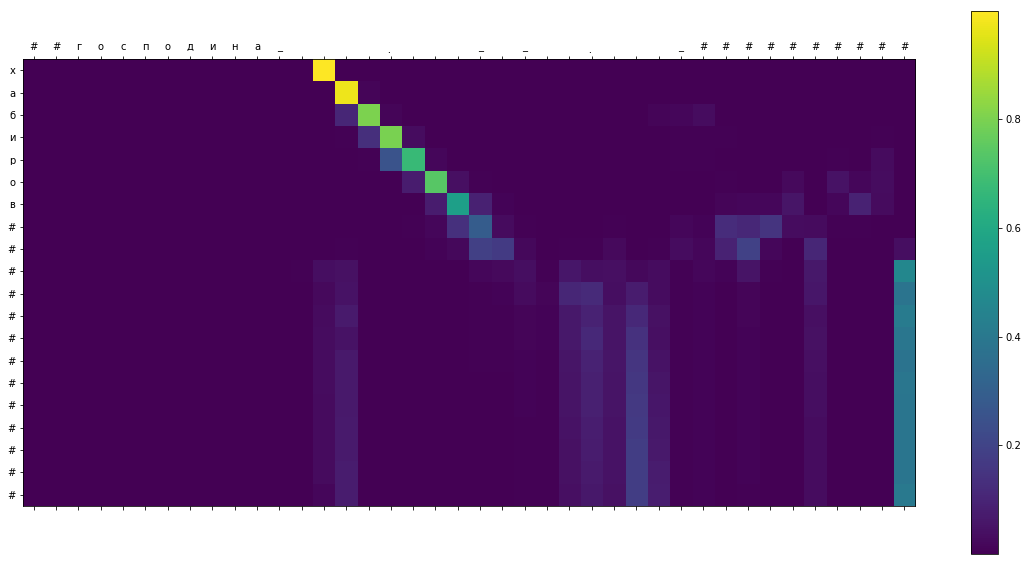

In [78]:
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

In [67]:
ethalons, results, inputs, matched, distances = trainer.test_model(False)

results_cleaned_2_3.csv

In [54]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.801149425287
Mean distance:  0.307471264368


results_cleaned_2_5.csv

In [68]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.811781609195
Mean distance:  0.316666666667


In [49]:
print(ethalons[:10])
print(results[:10])
print(inputs[:10])
print(matched[:10])
print(distances[:10])

['игорь артемьев', 'михаил прохоров', 'игорь андрющенко', 'ровенский', 'ровенский', 'алексей миллер', 'юрий хардиков', 'айрат мурзагалиев', 'андрей воробьев', 'андрей раппопорт']
['игорь артемьев', 'михаил прохоров', 'игорь андрющенко', 'ровенский', 'ровенский', 'алексей миллер', 'юрий хардиков', 'айрат мурзагалиев', 'андрей воробьев', 'андрей раппопорт']
['глава фас игорь артемьев заявил, ч', 'году, при михаиле прохорове.\n\r\n\rкроме', 'правлению игорь андрющенко называет ', ' господин ровенский, позиция,', 'господина ровенского, он с 1 и', 'газпрома> алексея миллера, члена со', 'ектом сао юрием хардиковым. 19 январ', 'резидента айрат мурзагалиев, вчера му', 'й россии" андрей воробьев заявил "ъ', 'андрей раппопорт выбрался ']
[True, True, True, True, True, True, True, True, True, True]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


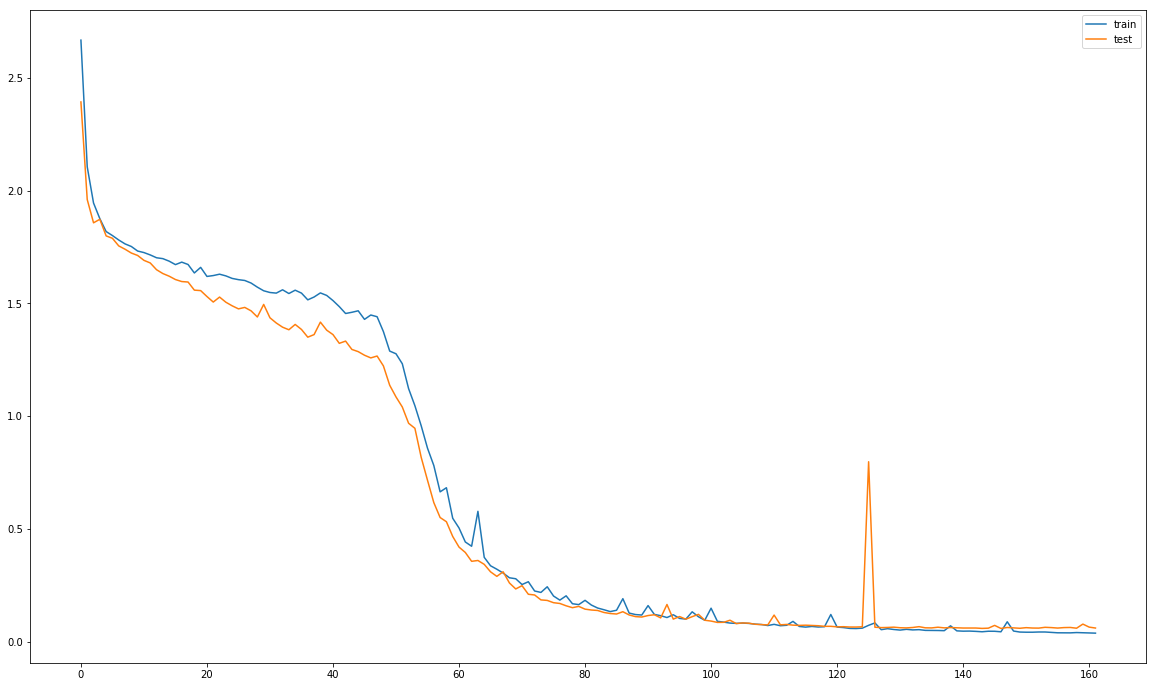

In [83]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all, label='train')
plt.plot(test_losses_all, label='test')
plt.legend()
plt.show()

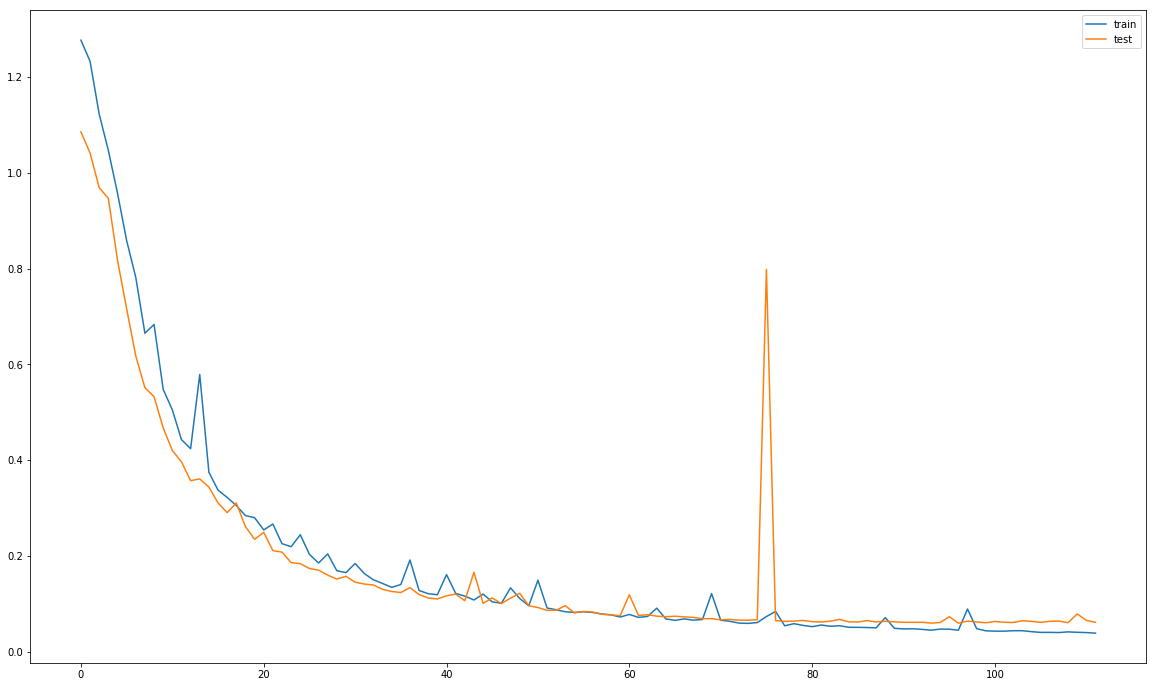

In [84]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all[50:], label='train')
plt.plot(test_losses_all[50:], label='test')
plt.legend()
plt.show()

In [69]:
encoded_inputs = list(map(lambda x : x.encode('windows-1251', errors='replace').decode('windows-1251'), inputs))

In [70]:
import pandas as pd

data = {'ethalon' : ethalons, 'result' : results, 'input' : encoded_inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])

In [71]:
df.head(20)

,ethalon,result,input,matched,distance
0,григорий карасин,григорий карасин,ел россии григорий карасин заявил в,True,0
1,путин,путин,недоимки. путин попросил,True,0
2,путин,путин,а котором путин раскритик,True,0
3,путин,путин,"по мнению путина, это дела",True,0
4,путин,путин,ступления путина глава фас,True,0
5,путин,путин,"ступления путина, его ведо",True,0
6,буш,буш,ия с сша. буш несколько,True,0
7,игорь юсуфов,игорь юсуфов,"дничеству игоря юсуфова, председа",True,0
8,хабиров,хабиров,господина хабирова в партии,True,0
9,хабиров,хабиров,господин хабиров был пригл,True,0


In [72]:
df.to_csv('results_cleaned_2_5.csv', encoding='windows-1251')

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(),'decoder.pt')

# Сгенерированные сущности для проверки механизма
Сущности имеют вид: [Основа прилагательного(3-7 символов)] + [окончание соотв роду] + [Основа cуществительного(3-7 символов)] + [окончание соотв роду] + [Глагол в одном из двух падежей]

In [1]:
from mockentries import two_case_entries

entries = two_case_entries(20)
for entry in entries:
    print(entry)

Offset:0	Length:20	Value:bhch ffgdfe	Context:bhcha ffgdfea chhbbu	Context offset:0
Offset:0	Length:18	Value:gceea fbbeda	Context:gceeou fbbedu bfdu	Context offset:0
Offset:0	Length:18	Value:edebd dec	Context:edebda deca febhdu	Context offset:0
Offset:0	Length:19	Value:defa hgbhheha	Context:defa hgbhheha cccba	Context offset:0
Offset:0	Length:17	Value:fhgbeba chha	Context:fhgbeba chha gffa	Context offset:0
Offset:0	Length:18	Value:cfdhbha chfa	Context:cfdhbhou chfu dhbu	Context offset:0
Offset:0	Length:18	Value:hbgca hfdbba	Context:hbgca hfdbba efcba	Context offset:0
Offset:0	Length:22	Value:bbce dhbfed	Context:bbcea dhbfeda bbgbbegu	Context offset:0
Offset:0	Length:21	Value:fbbeeeh hhcdbhd	Context:fbbeeeh hhcdbhd hcebf	Context offset:0
Offset:0	Length:17	Value:dddba bdda	Context:dddbou bddu dfgfu	Context offset:0
Offset:0	Length:24	Value:gddcgda ceceheba	Context:gddcgda ceceheba fhbdefa	Context offset:0
Offset:0	Length:22	Value:fbhgea dbchdeca	Context:fbhgea dbchdeca edbeca	Context off

In [3]:
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

In [4]:
entries = two_case_entries(30000)
ep = EntriesProcessor(20, 40,0)
# voc_size = 10
ep.process(entries)
voc_size = ep.symbols_counter
print(len(ep.X_data_test), len(ep.X_data_train))

3003 26997


In [5]:
EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [7]:
train_losses_all, test_losses_all = [], []

In [20]:
train_losses, test_losses = trainer.train(20, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.851337 	 Time: 20s
	Test Loss: 0.783537 	 Time: 0s
Epoch 2
	Train Loss: 0.832669 	 Time: 20s
	Test Loss: 0.753233 	 Time: 0s
Epoch 3
	Train Loss: 0.782680 	 Time: 20s
	Test Loss: 0.732383 	 Time: 0s
Epoch 4
	Train Loss: 0.805313 	 Time: 20s
	Test Loss: 0.695999 	 Time: 0s
Epoch 5
	Train Loss: 0.831109 	 Time: 21s
	Test Loss: 0.693417 	 Time: 0s
Epoch 6
	Train Loss: 0.737945 	 Time: 20s
	Test Loss: 0.638591 	 Time: 0s
Epoch 7
	Train Loss: 0.710886 	 Time: 20s
	Test Loss: 0.605180 	 Time: 0s
Epoch 8
	Train Loss: 0.680344 	 Time: 20s
	Test Loss: 0.552253 	 Time: 0s
Epoch 9
	Train Loss: 0.663991 	 Time: 20s
	Test Loss: 0.519573 	 Time: 0s
Epoch 10
	Train Loss: 0.577398 	 Time: 20s
	Test Loss: 0.477038 	 Time: 0s
Epoch 11
	Train Loss: 0.563474 	 Time: 20s
	Test Loss: 0.417709 	 Time: 0s
Epoch 12
	Train Loss: 0.527981 	 Time: 20s
	Test Loss: 0.361324 	 Time: 0s
Epoch 13
	Train Loss: 0.421125 	 Time: 20s
	Test Loss: 0.311936 	 Time: 0s
Epoch 14
	Train Loss: 0.453693 	 

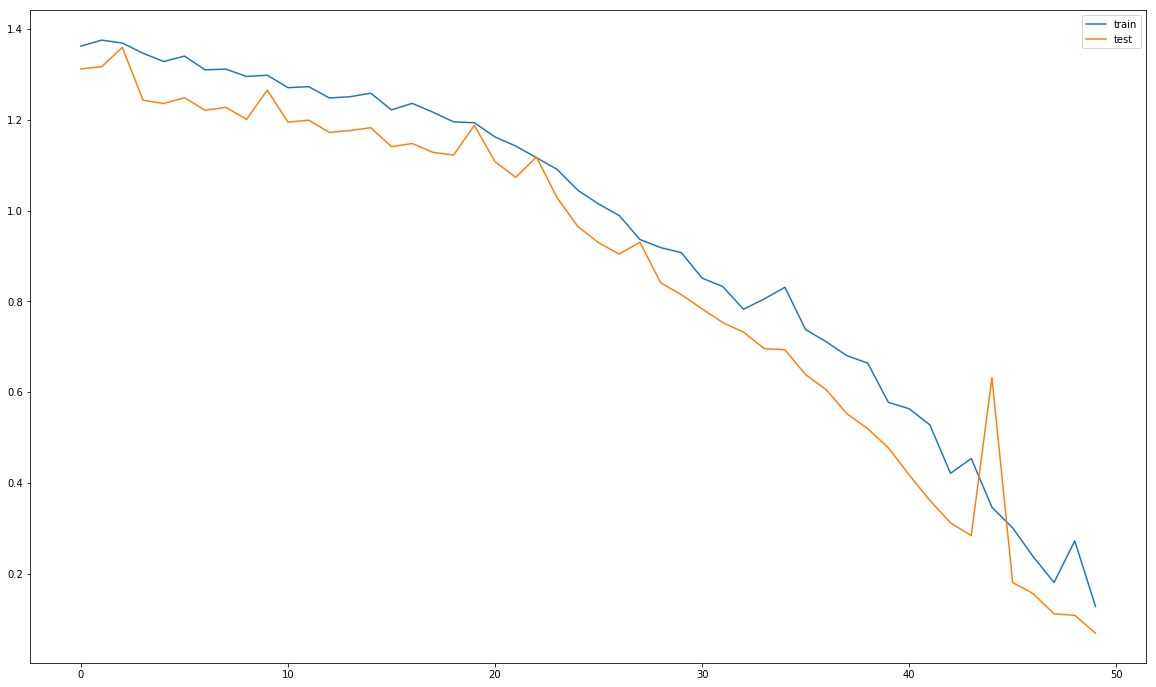

In [21]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all, label='train')
plt.plot(test_losses_all, label='test')
plt.legend()
plt.show()

In [13]:
ep.symbols_dict

{' ': 12,
 '<EOS>': 1,
 '<PAD>': 0,
 '<SOS>': 2,
 '<UNK>': 3,
 'a': 4,
 'b': 7,
 'c': 8,
 'd': 6,
 'e': 11,
 'f': 10,
 'g': 3,
 'h': 9,
 'o': 13,
 'u': 5}

In [14]:
ep.X_data_test[0]


array([  0.,   2.,  10.,   9.,  11.,   3.,  10.,  10.,  11.,   4.,  12.,
        11.,   6.,   6.,   8.,   3.,  11.,   6.,   4.,  12.,   9.,  11.,
        10.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [15]:
ep.y_data_test[0]

array([ 10.,   9.,  11.,   3.,  10.,  10.,  11.,   4.,  12.,  11.,   6.,
         6.,   8.,   3.,  11.,   6.,   4.,   1.,   0.,   0.])

['#', '#', 'f', 'h', 'e', 'g', 'f', 'f', 'e', 'a', '_', 'e', 'd', 'd', 'c', 'g', 'e', 'd', 'a', '_', 'h', 'e', 'f', 'a', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


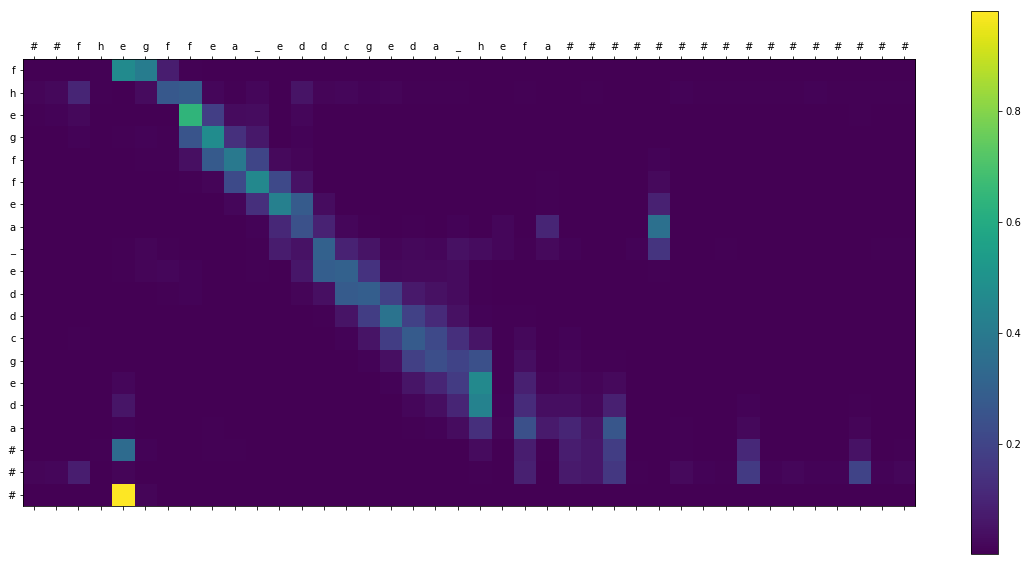

In [22]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[0:1])
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

['#', '#', 'd', 'f', 'g', 'g', 'h', 'd', 'd', 'o', 'u', '_', 'c', 'b', 'h', 'u', '_', 'h', 'f', 'e', 'u', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


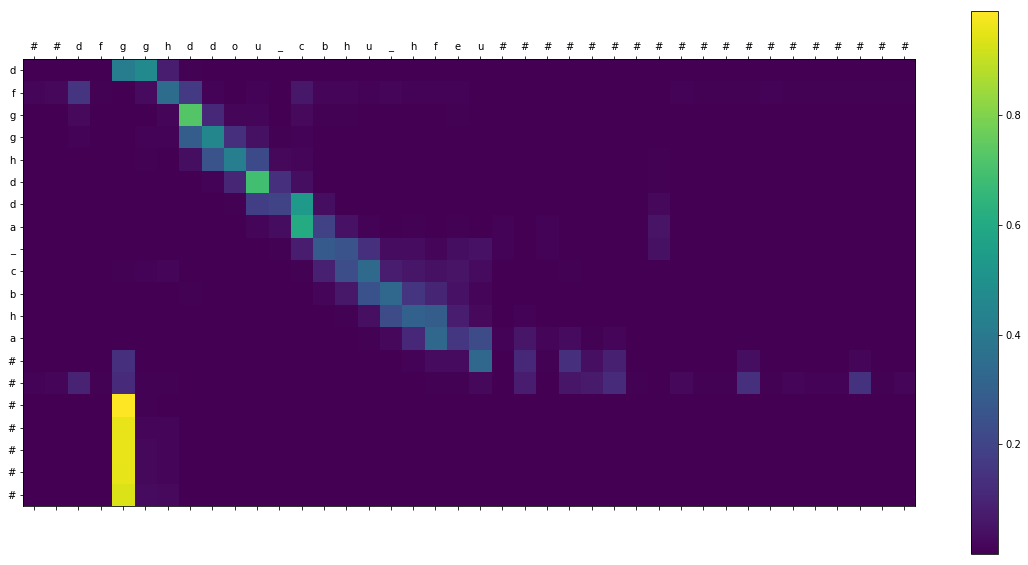

In [24]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[2:3])
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

['#', '#', 'h', 'g', 'e', 'e', 'b', 'f', '_', 'd', 'h', 'h', 'c', '_', 'h', 'd', 'f', 'g', 'f', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


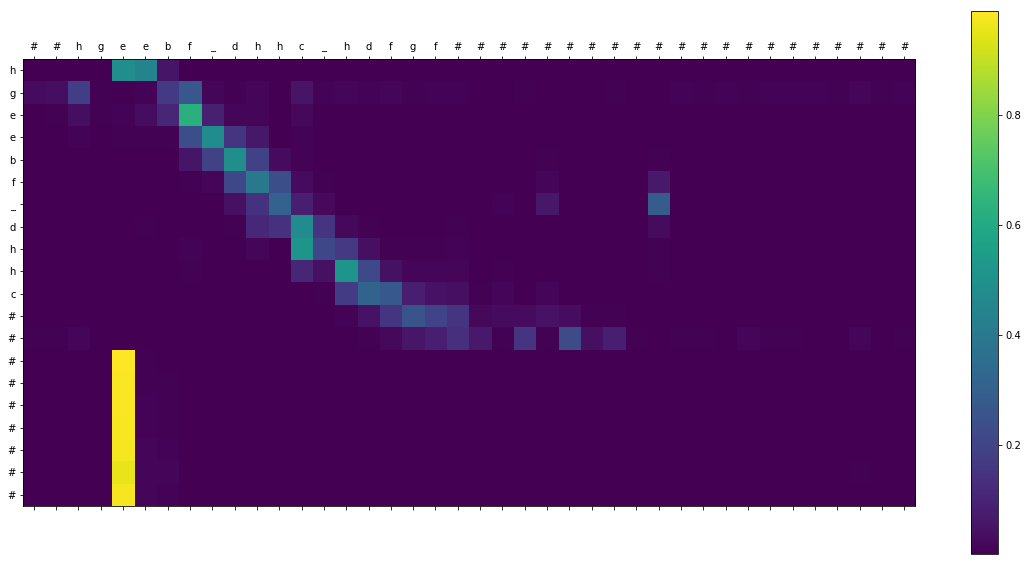

In [25]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[3:4])
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

['#', '#', 'b', 'g', 'f', 'g', 'o', 'u', '_', 'h', 'c', 'e', 'd', 'g', 'e', 'u', '_', 'd', 'e', 'e', 'g', 'c', 'u', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


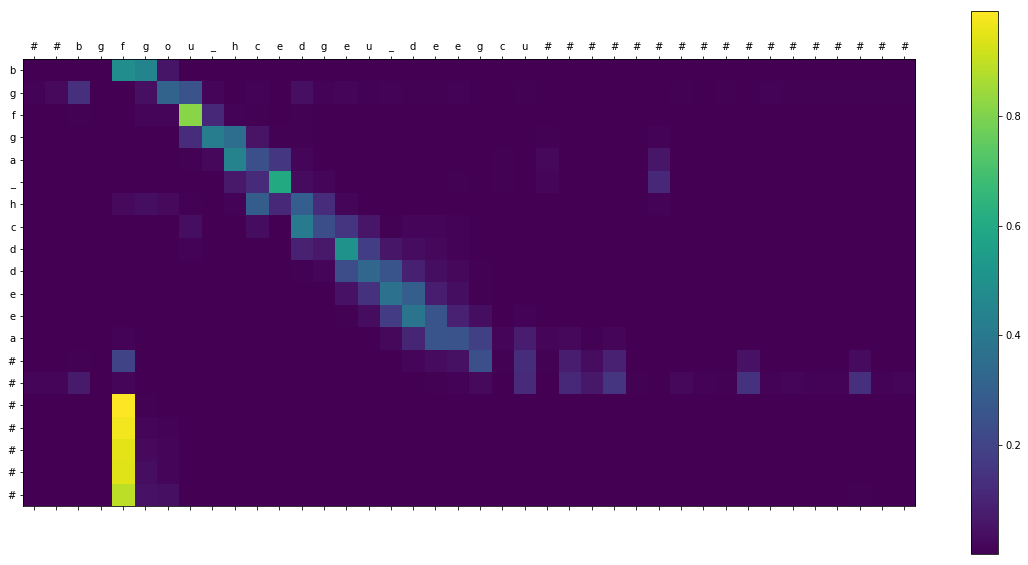

In [26]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[4:5])
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

# Pytorch CRF

In [12]:
from entriesprocessor import EntriesProcessor
from trainerpytorchcrf import TrainerPythonCRF
from model import Encoder, DecoderPythonCRF
from mockentries import two_case_entries
import torch

In [2]:
entries = two_case_entries(30000)
ep = EntriesProcessor(20, 40, 0)
# voc_size = 10
ep.process(entries)
voc_size = ep.symbols_counter
print(len(ep.X_data_test), len(ep.X_data_train))
EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = DecoderPythonCRF(hidden_size=HIDDEN_SIZE,
                           embedding_size=EMBEDDING_SIZE,
                           output_size=voc_size,
                           max_length=40).to(device)
trainer = TrainerPythonCRF(encoder, decoder, ep, max_input_length=40, max_output_length=20, device=device)


3000 27000


In [22]:
trainer.train(20, batch_size=512)


Epoch 1
	Train Loss: 0.727413 	 Time: 14s
Epoch 2
	Train Loss: 0.705551 	 Time: 14s
Epoch 3
	Train Loss: 0.723971 	 Time: 14s
Epoch 4
	Train Loss: 0.676693 	 Time: 14s
Epoch 5
	Train Loss: 0.718180 	 Time: 15s
Epoch 6
	Train Loss: 0.634068 	 Time: 14s
Epoch 7
	Train Loss: 0.605566 	 Time: 14s
Epoch 8
	Train Loss: 0.634771 	 Time: 14s
Epoch 9
	Train Loss: 0.693963 	 Time: 14s
Epoch 10
	Train Loss: 0.662667 	 Time: 14s
Epoch 11
	Train Loss: 0.604051 	 Time: 14s
Epoch 12
	Train Loss: 0.653985 	 Time: 14s
Epoch 13
	Train Loss: 0.612999 	 Time: 14s
Epoch 14
	Train Loss: 0.659264 	 Time: 14s
Epoch 15
	Train Loss: 0.648727 	 Time: 15s
Epoch 16
	Train Loss: 0.666188 	 Time: 15s
Epoch 17
	Train Loss: 0.606501 	 Time: 15s
Epoch 18
	Train Loss: 0.606535 	 Time: 14s
Epoch 19
	Train Loss: 0.648370 	 Time: 14s
Epoch 20
	Train Loss: 0.622488 	 Time: 15s


([0.727413054625943,
  0.7055505573187234,
  0.723970743282786,
  0.6766929871068811,
  0.7181796996660952,
  0.6340680164548586,
  0.6055662682596242,
  0.6347711820085093,
  0.6939627682825305,
  0.6626668538687364,
  0.6040513085306816,
  0.6539846341002662,
  0.6129994167471832,
  0.6592636406421661,
  0.6487269769862013,
  0.6661881416473748,
  0.6065006216741958,
  0.6065347458956376,
  0.6483698903389696,
  0.6224881121010151],
 [])

In [23]:
ethalons, results, inputs, matched, distances = trainer.test_model(False, 100)

In [24]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.0
Mean distance:  8.09


In [25]:
print(results[:10])

[['e', 'e', 'f', 'd', 'e', 'c', 'a', ' ', 'h', 'b', 'c', 'b', 'c', 'h', 'a', 'a', '<EOS>', 'h', 'c', '<EOS>'], ['e', 'h', 'd', 'e', 'a', ' ', 'g', 'g', 'c', 'f', 'c', 'g', 'g', 'a', ' ', 'g', 'g', 'c', 'g', '<EOS>'], ['h', 'g', 'e', 'c', 'd', 'g', 'e', ' ', 'h', 'e', 'f', 'g', 'd', 'd', 'e', 'd', 'a', ' ', 'h', '<EOS>'], ['h', 'h', 'g', 'f', 'a', ' ', 'f', 'd', 'e', 'b', 'd', 'a', '<EOS>', 'g', 'c', 'a', '<EOS>', 'c', 'a', '<EOS>'], ['f', 'f', 'd', ' ', 'd', 'c', 'f', 'g', 'g', 'a', ' ', 'g', 'c', 'e', 'h', 'e', 'e', 'h', 'g', '<EOS>'], ['e', 'e', 'b', 'a', ' ', 'c', 'e', 'h', 'f', 'a', '<EOS>', 'e', 'd', 'b', 'b', 'f', 'd', 'f', 'a', '<EOS>'], ['c', 'c', 'b', 'd', 'b', ' ', 'c', 'c', 'g', 'd', 'f', 'd', 'g', 'g', 'f', 'h', 'g', 'g', 'd', '<EOS>'], ['e', 'g', 'e', 'b', 'h', 'e', 'd', 'a', ' ', 'b', 'g', 'b', 'f', 'a', ' ', 'd', 'a', '<EOS>', 'a', '<EOS>'], ['c', 'c', 'b', ' ', 'b', 'e', 'c', 'g', 'e', 'h', 'd', '<EOS>', 'c', 'e', 'g', 'g', 'e', 'g', 'h', '<EOS>'], ['h', 'b', 'h', 'g', 

In [26]:
inputs[:10]

['eefdecou hbcbchu bdfu',
 'ehdeou ggcfcggu dheu',
 'hgecdgea hefgdeda hcgu',
 'hhgfa fdebda gcchcbgu',
 'ffda dcfga gceheha',
 'eeba cehfa edbbfda',
 'ccbdb ccgdfdg fhgdbg',
 'egebheda bgbfa decba',
 'ccb becgehd ceg',
 'hbhgbou gggeedgu bhcffhgu']

In [27]:
for res in results[:10]:
    print("".join(filter(lambda x: len(x) == 1, res)))

eefdeca hbcbchaahc
ehdea ggcfcgga ggcg
hgecdge hefgddeda h
hhgfa fdebdagcaca
ffd dcfgga gceheehg
eeba cehfaedbbfdfa
ccbdb ccgdfdggfhggd
egebheda bgbfa daa
ccb becgehdceggegh
hbhgba gggeedga gge


# PytorchCRF on real data

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = DecoderPythonCRF(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = TrainerPythonCRF(encoder,decoder,ep,max_input_length=40, max_output_length=20, device=device)

In [14]:
train_losses_all, test_losses_all = [], []

In [22]:
train_losses, test_losses = trainer.train(1, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.480692 	 Time: 34s
	Test Loss: 0.971144 	 Time: 1s


In [27]:
import numpy as np
ethalons, results, inputs, matched, distances = trainer.test_model(False)
results2 = list(map(lambda x: ''.join(filter(lambda y: len(y) == 1, x)), results))
distances = list(map(lambda x: distance(x[0],x[1]), zip(results2, ethalons) ))
matched = list(map(lambda x: x[0] == x[1], zip(results2, ethalons)))
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.864704293816
Mean distance:  0.208749662436


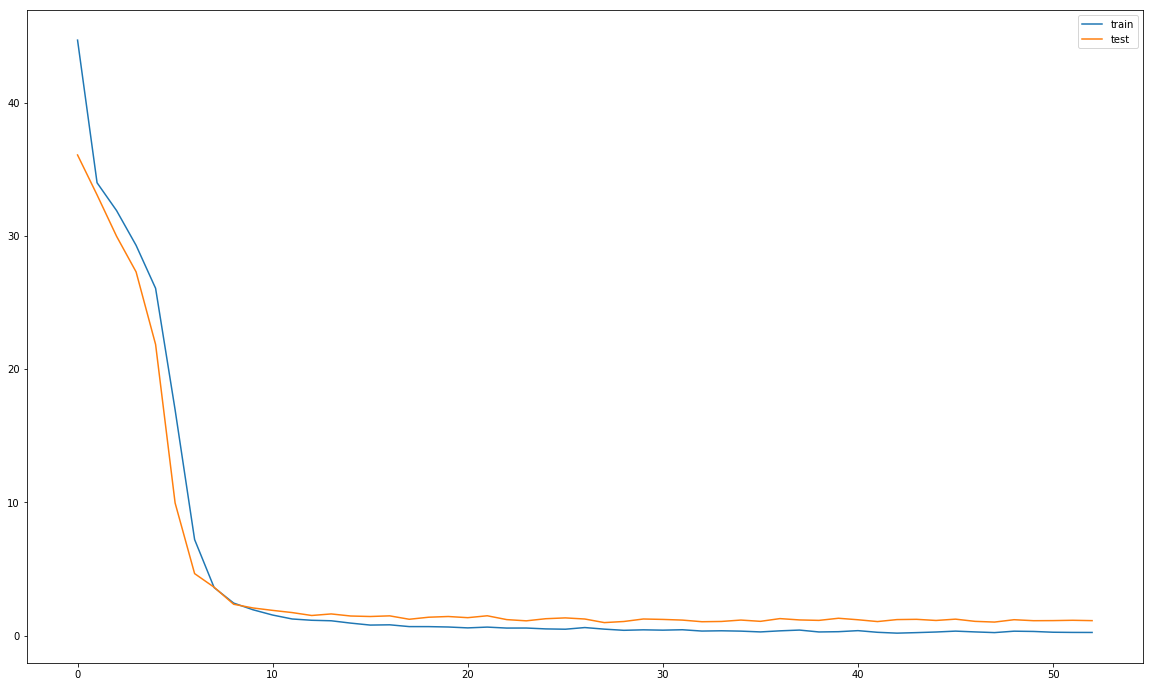

In [34]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all, label='train')
plt.plot(test_losses_all, label='test')
plt.legend()
plt.show()

In [24]:
import pandas as pd
encoded_inputs = list(map(lambda x : x.encode('windows-1251', errors='replace').decode('windows-1251'), inputs))
data = {'ethalon' : ethalons, 'result' : results2, 'input' : encoded_inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])
df.head(20)

,ethalon,result,input,matched,distance
0,владимир путин,владимир путин,онце июля владимир путин на совеща,True,0
1,игорь чайка,игорь чайка,нпрокурор игорь чайка также пос,True,0
2,игорь андрющенко,игорь андрющенко,правлению игорь андрющенко называет,True,0
3,игорь юсуфов,игорь юсуфов,"дничеству игоря юсуфова, председа",True,0
4,алексей миллер,алексей миллер,"газпрома> алексея миллера, члена со",True,0
5,елена карпель,елена карпель,разования елена карпель и зампред,True,0
6,олег митволь,олег митволь,олег митволь высадился,True,0
7,олег митволь,олег митволь,однадзора олег митволь должен бы,True,0
8,юрий лужков,юрий лужков,""" с мэром юрием лужковым, уточняя,",True,0
9,олег митволь,олег митволь,ом работы олега митволя станут ос,True,0


In [25]:
df.to_csv('results_crf_adam.csv', encoding='windows-1251')

In [35]:
matched = df.matched
distances = df.distance
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.876586551445
Mean distance:  0.17985417229273562


# PytorchCRF SGD result

In [70]:
train_losses, test_losses = trainer.train(20, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.913442 	 Time: 35s
	Test Loss: 1.436045 	 Time: 1s
Epoch 2
	Train Loss: 0.929385 	 Time: 35s
	Test Loss: 1.414033 	 Time: 1s
Epoch 3
	Train Loss: 0.905811 	 Time: 35s
	Test Loss: 1.432749 	 Time: 1s
Epoch 4
	Train Loss: 2.884688 	 Time: 36s
	Test Loss: 1.448829 	 Time: 1s
Epoch 5
	Train Loss: 1.098955 	 Time: 35s
	Test Loss: 1.516787 	 Time: 1s
Epoch 6
	Train Loss: 0.983404 	 Time: 36s
	Test Loss: 1.424907 	 Time: 1s
Epoch 7
	Train Loss: 0.935921 	 Time: 36s
	Test Loss: 1.403877 	 Time: 1s
Epoch 8
	Train Loss: 0.931202 	 Time: 34s
	Test Loss: 1.401187 	 Time: 1s
Epoch 9
	Train Loss: 0.894228 	 Time: 36s
	Test Loss: 1.433451 	 Time: 1s
Epoch 10
	Train Loss: 0.886990 	 Time: 34s
	Test Loss: 1.549615 	 Time: 1s
Epoch 11
	Train Loss: 0.873195 	 Time: 35s
	Test Loss: 1.443655 	 Time: 1s
Epoch 12
	Train Loss: 0.880239 	 Time: 36s
	Test Loss: 1.559212 	 Time: 1s
Epoch 13
	Train Loss: 0.888319 	 Time: 36s
	Test Loss: 1.378398 	 Time: 1s
Epoch 14
	Train Loss: 1.128171 	 

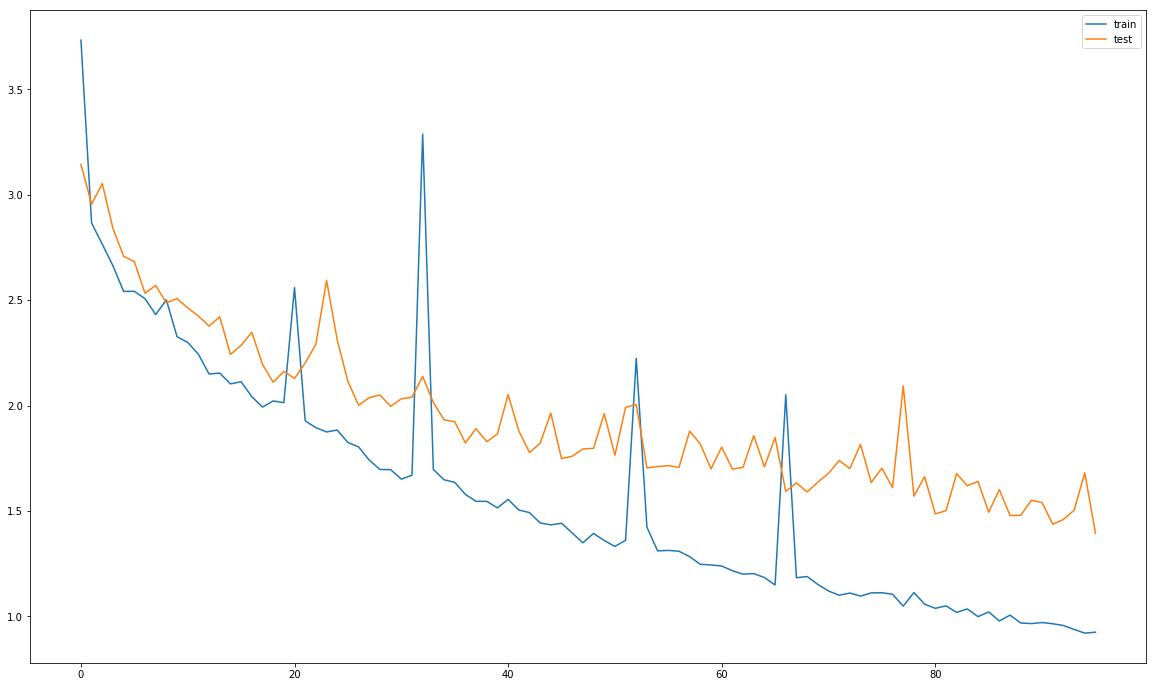

In [62]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all[50:], label='train')
plt.plot(test_losses_all[50:], label='test')
plt.legend()
plt.show()

In [61]:
import numpy as np
ethalons, results, inputs, matched, distances = trainer.test_model(False)
results2 = list(map(lambda x: ''.join(filter(lambda y: len(y) == 1, x)), results))
distances = list(map(lambda x: distance(x[0],x[1]), zip(results2, ethalons) ))
matched = list(map(lambda x: x[0] == x[1], zip(results2, ethalons)))
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.711595935445
Mean distance:  0.569037656904


In [66]:
import pandas as pd
encoded_inputs = list(map(lambda x : x.encode('windows-1251', errors='replace').decode('windows-1251'), inputs))
data = {'ethalon' : ethalons, 'result' : results2, 'input' : encoded_inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])

In [68]:
df.head(20)

,ethalon,result,input,matched,distance
0,путин,путин,недоимки. путин попросил,True,0
1,путин,путин,а котором путин раскритик,True,0
2,путин,путина,"по мнению путина, это дела",False,1
3,путин,путина,ступления путина глава фас,False,1
4,путин,путина,"ступления путина, его ведо",False,1
5,михаил прохоров,михаил прохоров,"году, при михаиле прохорове.\n\r\n\rкроме",True,0
6,фазиль измайлов,фазиль измайлов,фекта сао фазиля измайлова. это брат,True,0
7,фазиль измайлов,фазиль измайлов,стр. 4). фазиль измайлов в разгово,True,0
8,юрий хардиков,юрий хардиков,ектом сао юрием хардиковым. 19 январ,True,0
9,андрей воробьев,андрей воробьев,"й россии"" андрей воробьев заявил ""ъ",True,0


In [69]:
df.to_csv('results_crf.csv', encoding='windows-1251')